In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
from TableauImg import *
#ce module est rajouté uniquement pour la présentation de slides
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from functools import reduce
from scipy import stats
from functions import *
#Ce script est gracieusement fourni par OCR et comporte des fonctions d'affichage de:
#éboulis des valeurs propres, projection sur les plans factoriels, 
#cercle des corrélations, et dendrogramme.

#L'année que nous étudions ici est 2013, car c'est la dernière année pour laquelle nous possédons
#des chiffres pour toutes les données.

#La donnée DeltaPop% est calculée sur la période 2008-2013

#Nous étudions 174 pays.

In [2]:
Popu0813=pd.read_csv("./DATAFAO/FAOSTAT_Pop0813.csv")
#Population de chaque pays, en 2008 et 2013

In [3]:
Popu0813=Popu0813.drop(columns=["Domaine","Élément","Produit"]).rename(columns={"Valeur":"Population"})

In [4]:
Popu0813=Popu0813.iloc[Popu0813.index != 14]
#Dans cette table, la ligne 14 représente les (ex) Antilles néérlandaises, qui n'est pas repris en 2013.
#Nous l'enlevons tout de suite.

In [5]:
Popu2013=Popu0813.groupby(by="Année").get_group(2013).Population.values
Popu2008=Popu0813.groupby(by="Année").get_group(2008).Population.values

In [6]:
DeltaPop0813=Popu0813.groupby(by="Année").get_group(2013).drop(columns=["Année","Population"]).rename(columns={"Zone":"Pays"})

In [7]:
DeltaPop0813["DeltaPop%"]=(((Popu2013-Popu2008)/Popu2008)*100)/5
# /5 pour l'accroissement ANNUEL MOYEN
#sans le /5 donne la diff de population entre 2008 et 2013

In [8]:
DeltaPop0813["DeltaPop%"]=round(DeltaPop0813["DeltaPop%"],2)

In [9]:
DeltaPop0813.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 1 to 348
Data columns (total 2 columns):
Pays         174 non-null object
DeltaPop%    174 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [10]:
ProtAniProtTot=pd.read_csv("./DATAFAO/FAOSTAT_ProtAniProtTot.csv",header=1,names=["Pays","Prot","Source","Valeur"])

In [11]:
ProtAniProtTot=ProtAniProtTot.dropna(axis=0)
ProtAni=(ProtAniProtTot.groupby(by="Source").get_group("Produits Animaux"))
ProtTot=(ProtAniProtTot.groupby(by="Source").get_group("Total General"))

In [12]:
RapportProtAnim=ProtAniProtTot.groupby("Source").get_group("Total General")

In [13]:
RapportProtAnim["RapportProtAnim"]=(ProtAni.Valeur.values/ProtTot.Valeur.values)*100

/home/cyril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
RapportProtAnim=RapportProtAnim.drop(columns=["Source","Prot","Valeur"])

In [15]:
RapportProtAnim["RapportProtAnim"]=RapportProtAnim["RapportProtAnim"].round(2)

In [16]:
RapportProtAnim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 1 to 347
Data columns (total 2 columns):
Pays               174 non-null object
RapportProtAnim    174 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [17]:
ProtDispo=ProtTot[["Pays","Valeur"]]
ProtDispo=ProtDispo.rename(columns={"Valeur":"prot en gr/hab/jour"})

In [18]:
ProtDispo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 1 to 347
Data columns (total 2 columns):
Pays                   174 non-null object
prot en gr/hab/jour    174 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [19]:
KcalDispo=pd.read_csv("./DATAFAO/FAOSTAT_KcalDispo.csv",header=1,names=["Pays","a","b","Kcal/hab/j"])
KcalDispo=KcalDispo.drop(columns=["a","b"])
KcalDispo=KcalDispo.dropna(axis=0)

In [20]:
KcalDispo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 2 columns):
Pays          174 non-null object
Kcal/hab/j    174 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [21]:
Poulets_import=pd.read_csv("./DATAFAO/FAOSTAT_Poulet_import2013.csv")

In [22]:
Poulets_import=Poulets_import.drop(columns=["Domaine","Élément","Produit","Année"])
Poulets_import=Poulets_import.rename(columns={"Zone":"Pays","Valeur":"Poulets_import"})

In [23]:
Poulets_export=pd.read_csv("./DATAFAO/FAOSTAT_Poulet_export2013.csv")

In [24]:
Poulets_export=Poulets_export.drop(columns=["Domaine","Élément","Produit","Année"])
Poulets_export=Poulets_export.rename(columns={"Zone":"Pays","Valeur":"Poulets_export"})

In [25]:
Poulets_prod=pd.read_csv("./DATAFAO/FAOSTAT_Poulet_Prod2013.csv")

In [26]:
Poulets_prod=Poulets_prod.drop(columns=["Domaine","Élément","Produit","Année"])
Poulets_prod=Poulets_prod.rename(columns={"Zone":"Pays","Valeur":"Poulets_prod"})

In [27]:
dfs=[Poulets_export,Poulets_import,Poulets_prod]
df_poulets=reduce(lambda left,right: pd.merge(left,right,on="Pays",how="outer"),dfs)

In [28]:
df_poulets=df_poulets.fillna(0)
#Ici je considère que les NaN sont = 0

In [29]:
df_poulets["Poulets(tonnes)"]=(df_poulets.Poulets_import-df_poulets.Poulets_export+df_poulets.Poulets_prod)

In [30]:
df_poulets=df_poulets.drop(columns=["Poulets_export","Poulets_import","Poulets_prod"])
#Tableau contenant la "présence de poulets", c-à-d la production + l'importation - l'exportation

In [31]:
df_Popu13=Popu0813.groupby(by="Année").get_group(2013).drop(columns="Année").rename(columns={"Zone":"Pays"})
#données de la population

In [32]:
Poulets=pd.merge(df_Popu13,df_poulets,on="Pays",how="outer")

In [33]:
Poulets["Poulets(kg/hab)"]=round((Poulets["Poulets(tonnes)"]/Poulets.Population),2)

In [34]:
Poulets=Poulets.drop(columns=["Poulets(tonnes)","Population"]).dropna()

In [35]:
Poulets
#La variables Poulets(Kg/hab) est finalement créée.
#Elle est calculée comme étant : (la production + l'import - l'export) / la population

,Pays,Poulets(kg/hab)
0,Afghanistan,2.45
1,Afrique du Sud,37.41
2,Albanie,13.25
3,Algérie,6.89
4,Allemagne,12.86
5,Angola,16.31
6,Antigua-et-Barbuda,69.96
7,Arabie saoudite,49.06
8,Argentine,37.55
9,Arménie,13.35


In [36]:
PIBh=pd.read_csv("./DATAFAO/FAOSTAT_PIBh13.csv")
PIBh=PIBh.drop(columns=["Domaine","Élément","Produit","Année"]).rename(columns={"Valeur":"PIBh","Zone":"Pays"})

In [37]:
#PIBh=pd.merge(df_Popu13,PIBh,on="Pays",how="left")
#PIBh.loc[PIBh["PIBh"].isnull()]
#Les pays dont le PIBh est inconnu...

In [38]:
dfs=[ProtDispo,KcalDispo,DeltaPop0813,RapportProtAnim,PIBh,Poulets]

In [39]:
Recap=reduce(lambda left,right: pd.merge(left,right,on="Pays",how="left"),dfs)

In [40]:
Recap.loc[Recap["PIBh"].isnull()]
#Recap est le tableau complet constitué des 174 pays et contenant des NaN

,Pays,prot en gr/hab/jour,Kcal/hab/j,DeltaPop%,RapportProtAnim,PIBh,Poulets(kg/hab)
35,"Chine, Taiwan Province de",89.74,2997.0,0.28,48.46,NaN,26.50
42,Cuba,90.86,3409.0,-0.05,34.97,NaN,19.65
45,Djibouti,65.86,2607.0,1.56,22.91,NaN,2.05
104,Namibie,57.69,2171.0,1.82,33.89,NaN,12.18
109,Nouvelle-Calédonie,87.03,2853.0,1.42,60.11,NaN,44.23
121,Polynésie française,96.85,2927.0,1.06,65.89,NaN,59.07
132,République populaire démocratique de Corée,55.00,2094.0,0.54,18.31,NaN,1.33


In [41]:
Recap=Recap.set_index("Pays")

In [42]:
Recap_nonull=Recap.dropna()
#Nous créons ici le tableau sans données manquantes.

In [43]:
PaysMarcheSature=(Poulets_export[Poulets_export.Poulets_export>50000]).Pays
#Je décide d'enlever de la liste tous les pays dont l'exportation de poulets dépasse 50 000tonnes

In [44]:
Recap_nonull=Recap_nonull[~Recap_nonull.index.isin(PaysMarcheSature)]
Recap_nonull
#La liste finale que nous étudions comporte 142 pays

,prot en gr/hab/jour,Kcal/hab/j,DeltaPop%,RapportProtAnim,PIBh,Poulets(kg/hab)
Pays,,,,,,
Afghanistan,58.25,2090.0,2.60,20.98,1848.7,2.45
Albanie,111.42,3193.0,0.10,53.33,10492.8,13.25
Algérie,91.96,3296.0,1.95,27.17,13253.6,6.89
Angola,57.26,2473.0,3.45,32.13,6188.0,16.31
Antigua-et-Barbuda,83.71,2417.0,1.18,67.89,18823.8,69.96
Arabie saoudite,91.63,3255.0,1.87,43.58,49537.6,49.06
Arménie,90.04,2928.0,0.00,48.03,7727.9,13.35
Australie,106.28,3276.0,1.57,67.44,43118.1,44.84
Azerbaïdjan,93.15,3118.0,1.21,32.29,16593.2,10.52


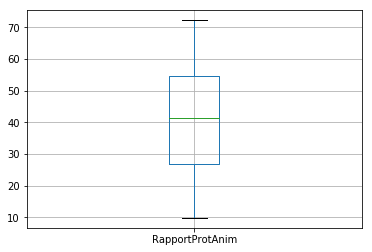

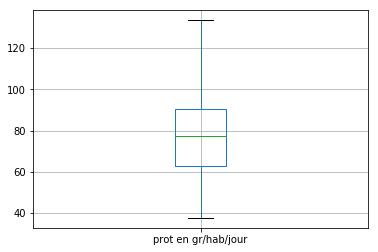

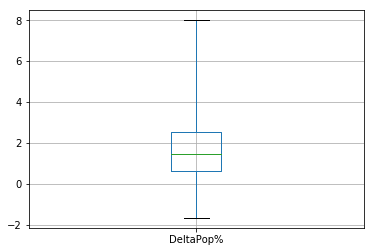

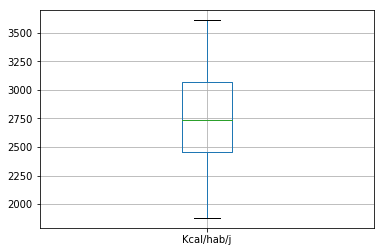

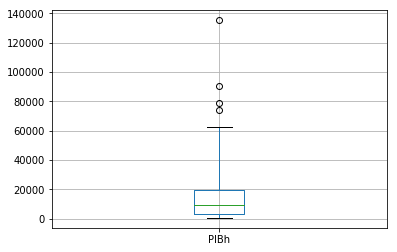

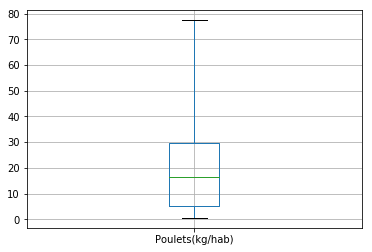

In [45]:
Recap_nonull[["RapportProtAnim"]].boxplot(whis=3)
plt.show()
Recap_nonull[["prot en gr/hab/jour"]].boxplot(whis=3)
plt.show()
Recap_nonull[["DeltaPop%"]].boxplot(whis=3)
plt.show()
Recap_nonull[["Kcal/hab/j"]].boxplot()
plt.show()
Recap_nonull[["PIBh"]].boxplot(whis=3)
plt.show()
Recap_nonull[["Poulets(kg/hab)"]].boxplot(whis=2)
plt.show()
#Dont voici la répartition des variables

In [46]:
#Notre échantillon est prêt, il est temps d'analyser tout ça.

X=Recap_nonull.values
std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled=std_scaler.transform(X)

#Ici,récupération des valeurs, centrage et réduction.

In [47]:
pays=Recap_nonull.index
#Pour usage ultérieur

In [48]:
Z=linkage(X_scaled,"ward")
#création de la "matrice de linkage" selon la méthode ward

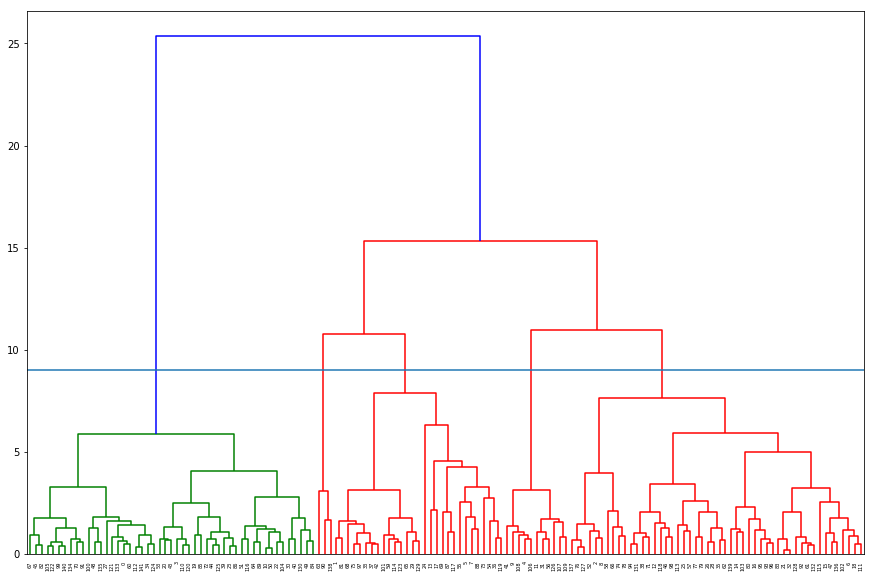

In [49]:
plt.figure(figsize=(15,10))
plt.axhline(9)
dendrogram(Z,labels=None)
#plt.savefig('Dendro.png', bbox_inches='tight')
plt.show()

In [50]:
#Méthode Ward
#Au vu de ce dendrogramme...
#Le choix de 5 clusters est assez aisé

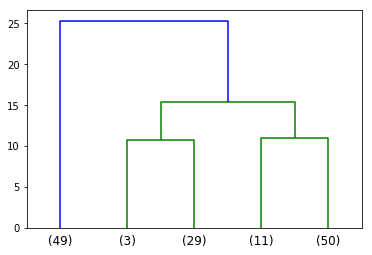

In [51]:
dendrogram(Z,
           truncate_mode="lastp",
           p=5)
#plt.savefig('DendroTrunc.png', bbox_inches='tight')
plt.show()


In [52]:
clusters=fcluster(Z,5,criterion="maxclust")

In [53]:
PaysCluster=pd.DataFrame({"Clusters":clusters, "Pays":pays})

In [54]:
#PaysCluster.to_csv("Pays_Cluster.csv")

In [55]:
Recap_nonull["Clusters"]=clusters

In [56]:
centroide=Recap_nonull.groupby("Clusters").mean()
#centroide.to_csv("centroide.csv")

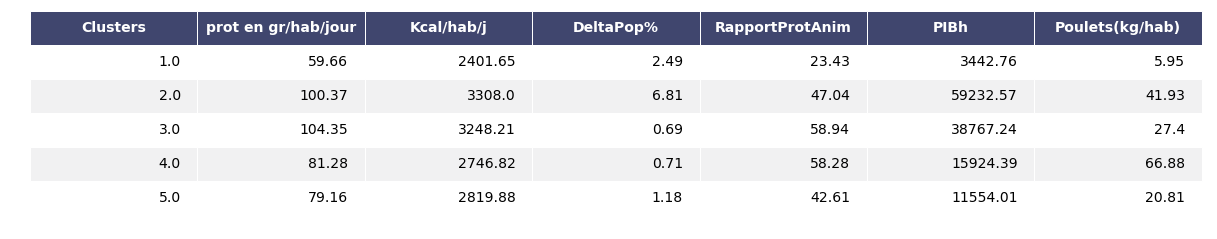

In [57]:
render_mpl_table(Recap_nonull.groupby("Clusters").mean().round(2).reset_index())
#plt.savefig("MoyClusters.png",bbox_inches='tight')


In [58]:
#Critiquons:
#C1 a un PIBh très faible
#C2 a un PIBh élevé, une belle croissance démographique mais beaucoup de poulets.
#C3 a un PIBh élevé, une croissance démographique faible et "assez peu" de poulets
#C4 a un PIBh moyen, croissance démo faible et surtout énormément de poulets.
#C5 a un PIBh moyen-faible, croissance démo correct, peu de poulets.

#Les groupes cibles seraient C3 et C5

In [59]:
Clust1=Recap_nonull.groupby("Clusters").get_group(1)
Clust2=Recap_nonull.groupby("Clusters").get_group(2)
Clust3=Recap_nonull.groupby("Clusters").get_group(3)
Clust4=Recap_nonull.groupby("Clusters").get_group(4)
Clust5=Recap_nonull.groupby("Clusters").get_group(5)

In [60]:
Clust5=pd.merge(Clust5.reset_index(),df_Popu13,how="left")
Clust3=pd.merge(Clust3.reset_index(),df_Popu13,how="left")
#A ce stade il devient intéressant de remettre la population dans les tableaux 
#que nous allons regarder de plus près

In [61]:
Clust3[(Clust3.PIBh>15000)&(Clust3["Poulets(kg/hab)"]<20)]
#Pays du cluster 3, avec un PIBh supérieur a 15 000dollars
#et une présence de poulets de - de 20kg/hab

,Pays,prot en gr/hab/jour,Kcal/hab/j,DeltaPop%,RapportProtAnim,PIBh,Poulets(kg/hab),Clusters,Population
6,Croatie,84.35,3059.0,-0.32,56.88,20271.3,7.36,3,4290
13,Kazakhstan,96.41,3264.0,1.12,59.18,22972.4,18.13,3,16441
16,Luxembourg,113.88,3539.0,1.77,63.33,90656.4,18.89,3,530
20,Norvège,110.90,3485.0,1.11,59.50,62896.3,19.03,3,5043
23,République de Corée,96.20,3334.0,0.58,47.95,32548.7,15.13,3,49263
25,Suisse,93.08,3391.0,1.11,64.21,56535.7,16.20,3,8078
26,Suède,107.72,3179.0,0.73,65.75,43475.8,19.38,3,9571
27,Tchéquie (la),87.47,3256.0,0.56,57.71,28379.7,19.79,3,10702
28,Uruguay,92.44,3050.0,0.35,58.42,19270.6,10.29,3,3407


In [62]:
Clust5[(Clust5.PIBh>15000)&(Clust5["Poulets(kg/hab)"]<20)]
#Pays du cluster 5 avec un PIBh supérieur a 15 000dollars
#et une présence de poulets de - de 20kg/hab

,Pays,prot en gr/hab/jour,Kcal/hab/j,DeltaPop%,RapportProtAnim,PIBh,Poulets(kg/hab),Clusters,Population
2,Azerbaïdjan,93.15,3118.0,1.21,32.29,16593.2,10.52,5,9413
6,Botswana,64.86,2326.0,0.90,40.72,15568.3,6.59,5,2021
7,Bulgarie,83.53,2829.0,-0.75,49.44,15997.4,17.08,5,7223
40,Slovaquie,72.51,2944.0,0.13,48.20,26580.7,15.77,5,5450


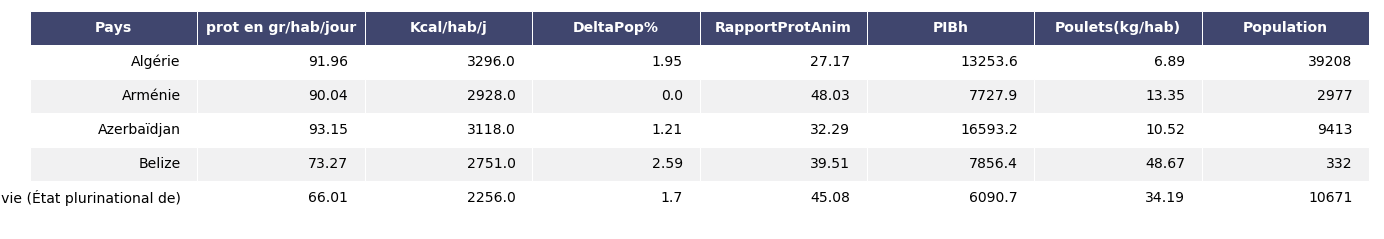

In [63]:
render_mpl_table(Clust5.head().drop(columns=("Clusters")))
#plt.savefig("Clust5ech.png",bbox_inches='tight')

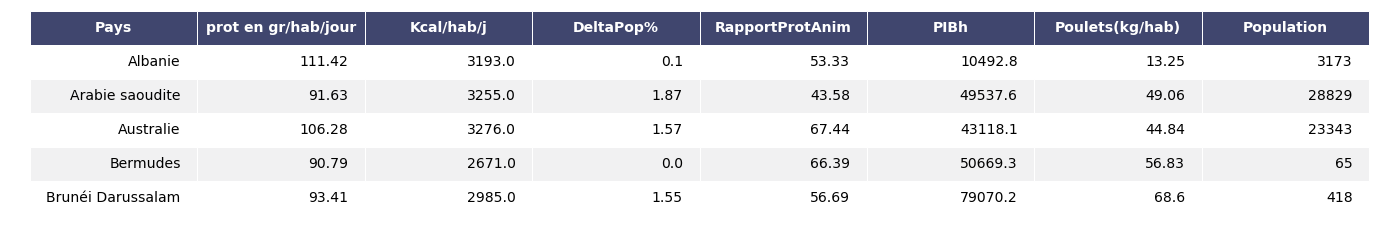

In [64]:
render_mpl_table(Clust3.head().drop(columns=("Clusters")))
#plt.savefig("Clust3ech.png",bbox_inches='tight')

In [65]:
#Ce qui nous donne une liste de 13 pays.
#On peut éliminer de la liste la Croatie et la Bulgarie pour leur croissance démographique négative.
#Le Luxembourg,la Suède et la Norvège pour leur disponibilités alimentaires déja excessives.

#Kazakhstan, Suisse, Tchéquie, Azerbaïdjan, Slovaquie

In [66]:
#Visualisez vos  partitions dans le premier plan factoriel obtenu par ACP.

In [67]:
PCA_data=Recap_nonull.drop(columns=("Clusters")).values
#la variable clusters n'a pas d'intérêt dans l'ACP
scaler=preprocessing.StandardScaler()
#Création du scaler
data_scaled=scaler.fit(PCA_data).transform(PCA_data)
#centrage et réduction

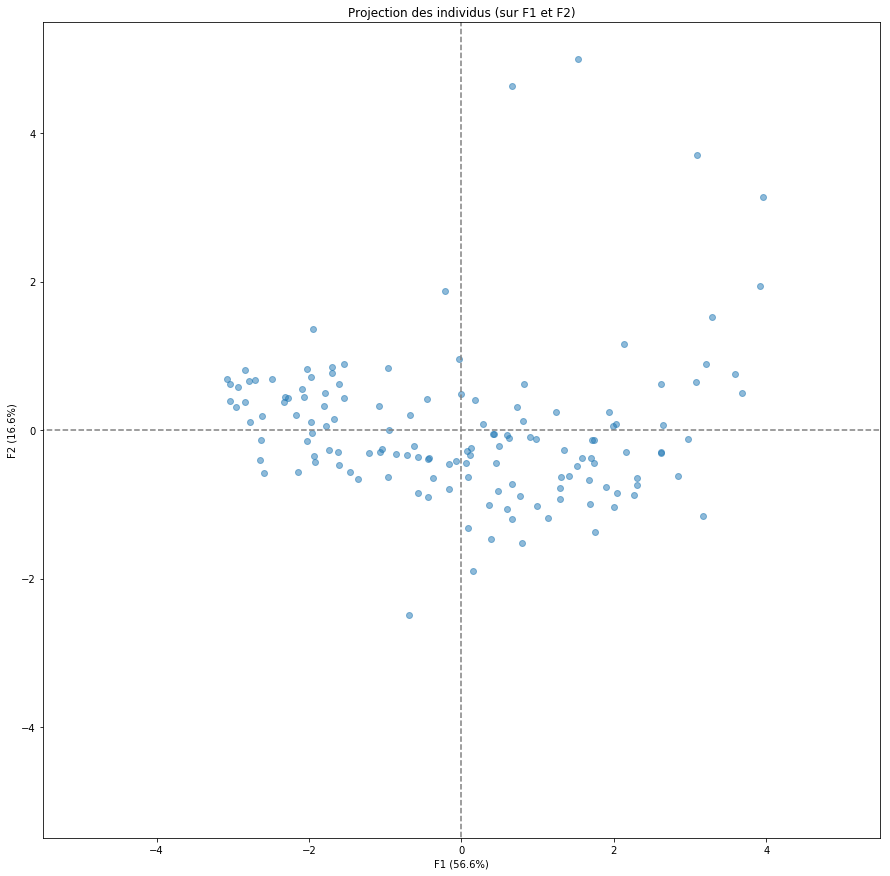

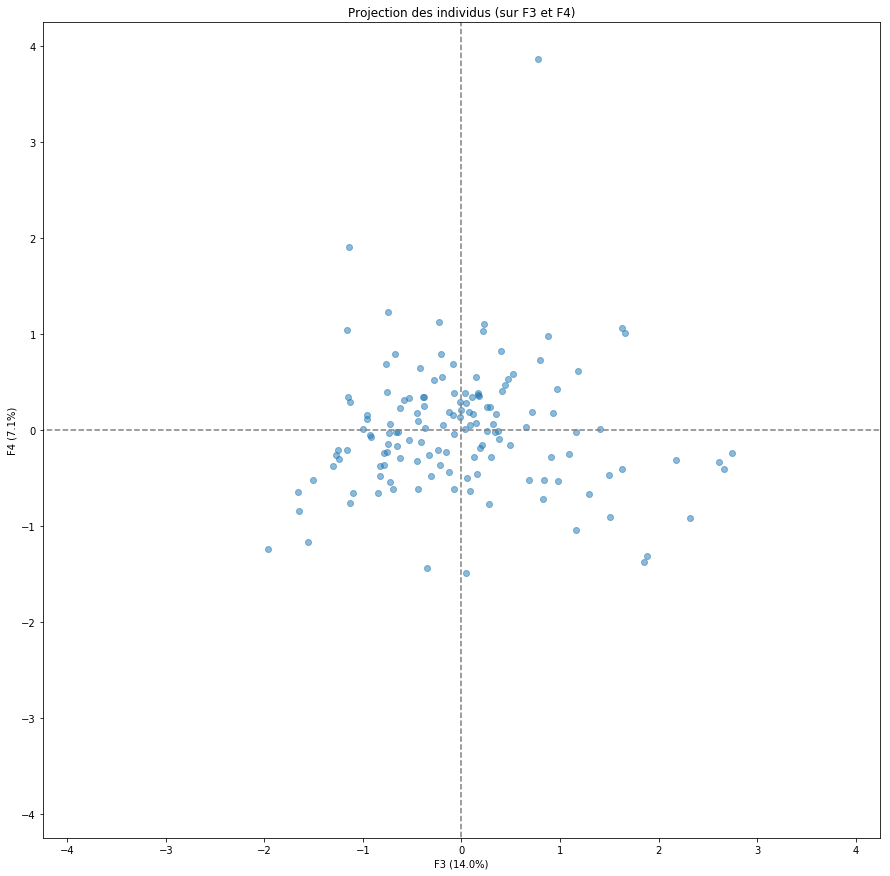

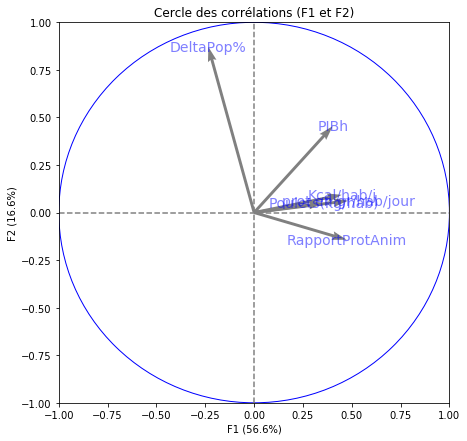

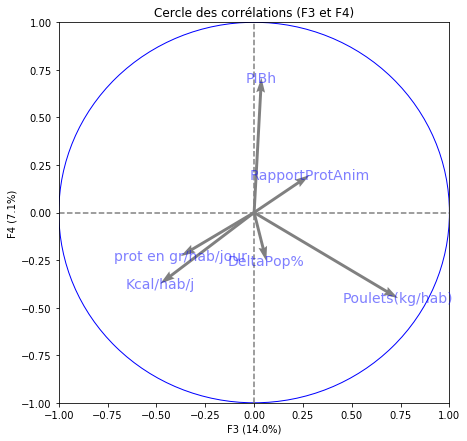

In [68]:
variables=Recap_nonull.columns

pca=decomposition.PCA(n_components=6)
pca.fit(data_scaled)
pcs=pca.components_
data_projected=pca.transform(data_scaled)
display_factorial_planes(data_projected,4,pca,[(0,1),(2,3)],alpha=0.5)
plt.show()
display_circles(pcs,6,pca,[(0,1),(2,3)],labels=variables)
#première visualisation des plans factoriels et cercle des corrélations

In [69]:
pcs
#chaque ligne est une composante = nouvelle variable = axe Fx
#chaque élément d'une ligne est le facteur associé a chaque variable initiale
#F1 = 0,48x"prot"+0,44x"Cal"-0.23x"Population"....

array([[ 0.48087434,  0.44869458, -0.23453428,  0.47382288,  0.40245028,
         0.35489767],
       [ 0.06189207,  0.09305537,  0.87086514, -0.14301238,  0.4540314 ,
         0.05006923],
       [-0.37546637, -0.48022266,  0.06259542,  0.28307192,  0.03744753,
         0.73685887],
       [-0.22909134, -0.37399763, -0.25488534,  0.19615813,  0.70819953,
        -0.45016864],
       [ 0.22208263, -0.24710754,  0.33585739,  0.73139482, -0.35603349,
        -0.33929153],
       [ 0.72259996, -0.59871838, -0.07001906, -0.31858002,  0.04669605,
         0.10396716]])

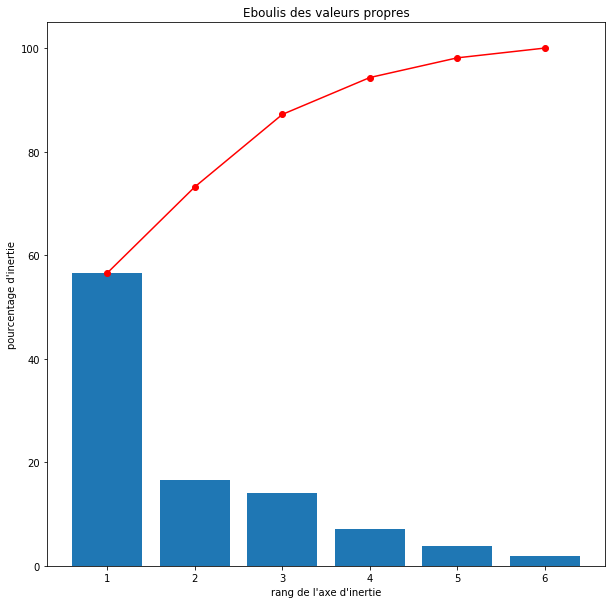

In [70]:
plt.figure(figsize=(10,10))
display_scree_plot(pca)

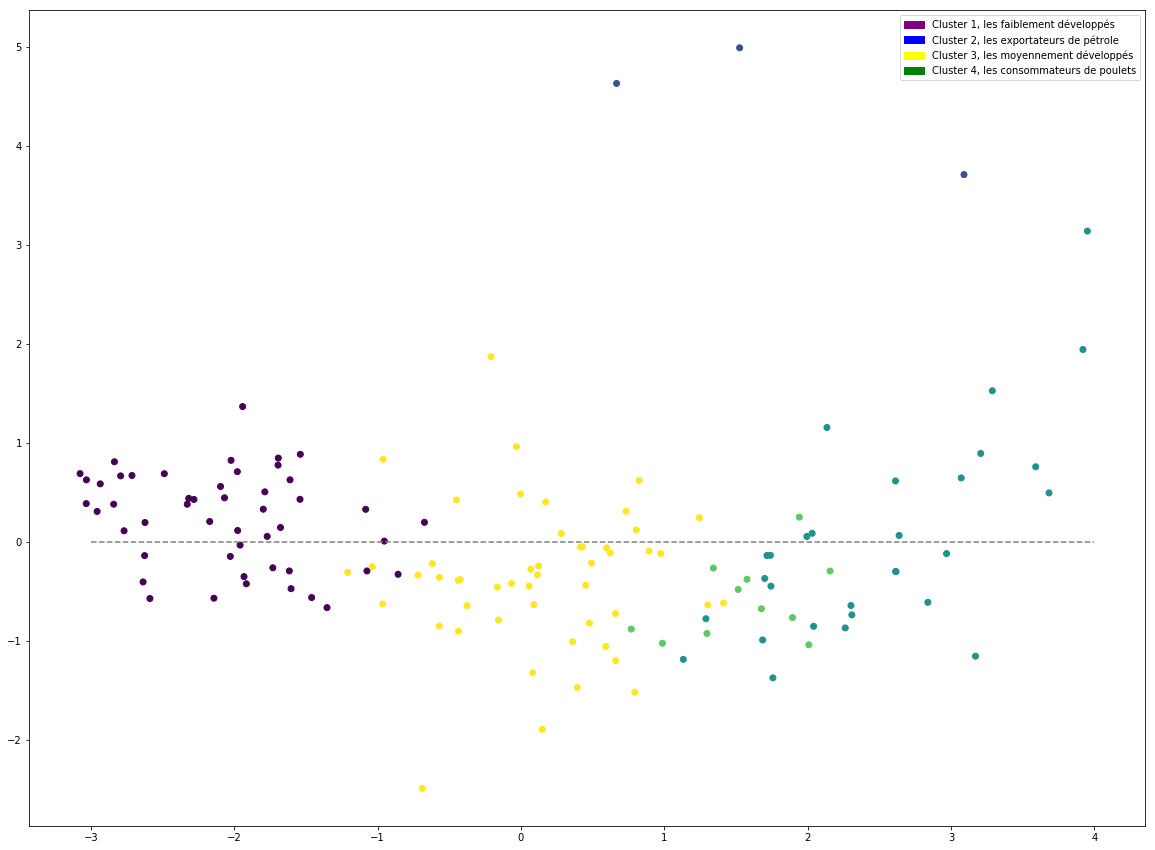

In [71]:
import matplotlib.patches as mpatches

yellow_patch = mpatches.Patch(color="yellow", label='Cluster 3, les moyennement développés')
purple_patch = mpatches.Patch(color='purple', label='Cluster 1, les faiblement développés')
blue_patch =  mpatches.Patch(color='blue', label='Cluster 2, les exportateurs de pétrole')
green_patch = mpatches.Patch(color='green', label='Cluster 4, les consommateurs de poulets')

plt.figure(figsize=(20,15))
plt.scatter(data_projected[:,0],data_projected[:,1],
            c=Recap_nonull.get("Clusters"))
plt.legend(handles=[purple_patch,blue_patch,yellow_patch,green_patch])
#Affichage des points

#for i, (x,y) in enumerate(zip(data_projected[:,0],
 #                             data_projected[:,1])):
  #  plt.text(x,y,Recap_nonull.index[i])
#Ajout des noms
plt.plot([-3,4],[0,0],color="grey",ls='--')
#Ajout de l'axe d'inertie principal F1
#plt.savefig("PrPlFa.png", bbox_inches="tight")
plt.show()

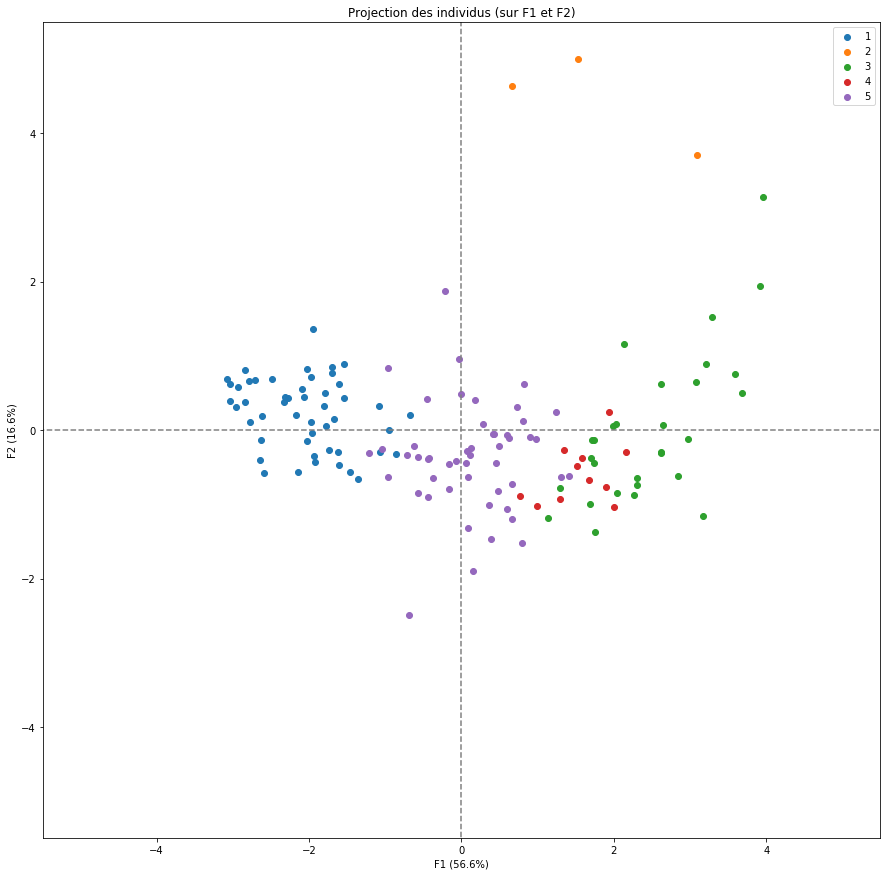

In [72]:

display_factorial_planes(data_projected, 6, pca, [(0,1)], 
                         illustrative_var = Recap_nonull["Clusters"], alpha = 0.99)


In [73]:
#Passons aux tests statistiques

In [74]:
#un test d'adéquation à la loi normale grâce a shapiro
#Prenons la variable des calories, et vérifions si elle suit une loi normale

In [75]:
stats.shapiro(Recap_nonull["Kcal/hab/j"])
#Le test de shapiro teste l'hypothèse nulle que la variable suit une loi normale
#Avec alpha=0.01 ou alpha=0.05 , p-value>alpha et nous ne rejetons pas H0 ==> la variable suit une loi normale.

(0.9824029803276062, 0.06501919776201248)

In [76]:
#un test de comparaison de deux populations (dans le cas gaussien) :
#il faut d'abord trouver une variable qui suive une loi normale dans 2 clusters différents

In [77]:
stats.shapiro(Clust2["Kcal/hab/j"])

(0.9819793701171875, 0.7428414225578308)

In [78]:
stats.shapiro(Clust1["Kcal/hab/j"])

(0.9846842288970947, 0.7681403160095215)

In [79]:
#Ensuite on les compare
stats.bartlett(Clust1["Kcal/hab/j"],Clust2["Kcal/hab/j"])
#on commencer par tester l'égalité des variances.
#la p-valeur élevée indique qu'on ne rejette pas l'hypothèse (H0) de l'égalité des variances

BartlettResult(statistic=0.2951716804120131, pvalue=0.5869252976888477)

In [80]:
stats.ttest_ind(Clust1["Kcal/hab/j"],Clust2["Kcal/hab/j"],equal_var=True)
#On obtient une p-valeur de l'ordre de 10^-7. On constate donc que l’hypothèse 
#d’égalité des valeurs moyennes des calories est (très facilement) rejetée à un niveau de test de 5%.
#Les clusters 1 et 2 se distinguent bien par leur moyenne de calories disponibles.

Ttest_indResult(statistic=-6.123840254910163, pvalue=1.4048118381456022e-07)

In [ ]:
#ATTENTION SHAPIRO = GRANDS ECHANTILLONS
#PETITES ECHANTILLONS = KOLGOROV SMIRNOV